# Download Data

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip -q "Project 1 - data.zip"


# Import Libraries

In [3]:
!pip -q install keras-layer-normalization

In [4]:
import os
import nltk
import math
import scipy
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D, Flatten, LSTM, Bidirectional
from keras_layer_normalization import LayerNormalization
from keras.utils import Sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Data Loader

In [7]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [8]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


In [9]:
train_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,39rLHYJOy2774ZIUouuWLw,0,2017-06-28 21:44:02,0,ynzOFepQYSCDGdfWDWxiZw,4,Nice to have a diner still around. Food was go...,0,Sl6VgFOB-XXfFIAYp7TFkw
1,E-Kq1Yu1d6N3TL2qX0aqjA,0,2018-04-09 03:45:19,0,sQX9ncJBEdBf16AWsvO6Vg,2,"Tried this a while back, got the fried chicken...",0,gcx01pMqWzkni2UC-zoZrA
2,nWW6fBfBljiRFa4sG7TyxA,0,2014-07-19 02:00:04,0,bVIf2kqbzvif3miNe3ARNw,4,I expected more pork selections on menu. Food ...,0,Mn9VzPbrCYU4EcP_C1oBOg
3,qmIHO-6T_KEfPC9jyGDamQ,0,2011-11-11 08:10:24,0,LNj1OFxy2ool3PZANGchPA,4,YUMMY!!! This place is phenomenal. It is Price...,0,SKV1heo00fdciCbCN9Z33A
4,pKk7jCFIm96qDdk0laVT2w,1,2010-01-16 20:04:00,1,bZXxa0hO6wQlHD-MkMf4iw,5,The Truffle Macaroni & Cheese and Potatoes Au ...,1,p1r7rZYruZR92x1A649PTQ


In [16]:
train_df["useful"].value_counts()

0      5032
1      2232
2      1068
3       542
4       340
5       231
6       121
7       104
8        71
9        43
10       40
12       25
11       23
13       21
14       15
16       14
17       11
15       10
18        9
19        7
21        4
28        4
23        4
20        3
22        3
26        3
25        2
33        2
24        2
27        2
42        1
50        1
82        1
31        1
29        1
37        1
53        1
48        1
30        1
38        1
54        1
247       1
Name: useful, dtype: int64

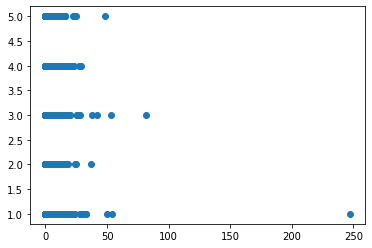

In [19]:
plt.scatter(train_df['useful'], train_df['stars'])

In [17]:
train_df["cool"].value_counts()

0     7632
1     1447
2      444
3      193
4       72
5       54
6       39
7       32
8       19
10      12
12       8
11       8
9        8
15       5
19       4
13       4
18       2
16       2
23       2
22       2
42       1
20       1
28       1
29       1
49       1
25       1
53       1
14       1
40       1
38       1
27       1
Name: cool, dtype: int64

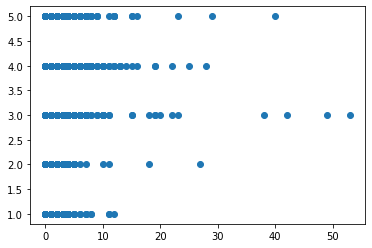

In [20]:
plt.scatter(train_df['cool'], train_df['stars'])

In [18]:
train_df["funny"].value_counts()

0     7625
1     1356
2      458
3      221
4      120
5       52
6       40
7       38
8       18
10      16
9       13
11      12
13       4
17       3
19       3
14       3
12       2
15       2
22       2
16       1
24       1
32       1
41       1
25       1
20       1
29       1
21       1
34       1
42       1
31       1
39       1
Name: funny, dtype: int64

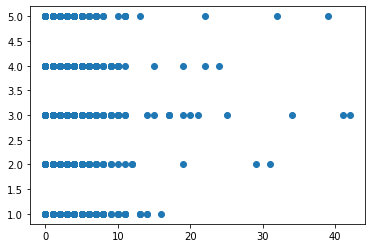

In [21]:
plt.scatter(train_df['funny'], train_df['stars'])

In [22]:
valid_df.describe()

,cool,funny,stars,useful
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.491000,0.544500,2.991500,1.404500
std,2.214581,2.484775,1.501851,3.356861
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,3.000000,0.000000
75%,0.000000,0.000000,4.000000,2.000000
max,79.000000,69.000000,5.000000,89.000000


# Feature Extractor

In [23]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [24]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

Bigram/Trigram better than Unigram in terms of Valid Accuracy

In [25]:
# load data
train_texts, train_labels = train_df["text"], train_df["stars"]
valid_texts, valid_labels = valid_df["text"], valid_df["stars"]

# extract features
train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
valid_2_gram = [n_gram(tokens, 2) for tokens in valid_stemmed]
valid_3_gram = [n_gram(tokens, 3) for tokens in valid_stemmed]

# build the feature list
train_feats = list()
for i in range(len(train_labels)):
    # train_feats.append(train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
    # train_feats.append(train_stemmed[i])
    train_feats.append(train_stemmed[i] + train_2_gram[i])
valid_feats = list()
for i in range(len(valid_labels)):
    # valid_feats.append(valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i])
    # valid_feats.append(valid_stemmed[i])
    valid_feats.append(valid_stemmed[i] + valid_2_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

Size of features: 29979


In [26]:
del train_tokens, train_stemmed, train_2_gram, train_3_gram
del valid_tokens, valid_stemmed, valid_2_gram, valid_3_gram

In [27]:
print(train_feats_matrix.shape, valid_feats_matrix.shape)
print(train_label_matrix.shape, valid_label_matrix.shape)

(10000, 29979) (2000, 29979)
(10000, 5) (2000, 5)


In [28]:
# train_feats_sparse = scipy.sparse.csr_matrix(train_feats_matrix)
# valid_feats_sparse = scipy.sparse.csr_matrix(valid_feats_matrix)

In [29]:
# train_feats_sparse.shape, valid_feats_sparse.shape

In [30]:
# train_feats_sparse.shape[0]

SLP

In [31]:
def build_classifier(input_size, output_size,
                     l2_reg=0.0,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     learning_rate=0.1,
                     metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a 1-layer perceptron,
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    # the projection layer
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    kernel_initializer=keras.initializers.he_normal(seed=0),
                    bias_initializer="zeros",
                    kernel_regularizer=keras.regularizers.l2(l2_reg)))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [33]:
os.makedirs("models", exist_ok=True)
model = build_classifier(input_size=len(feats_dict), output_size=num_classes,
                         l2_reg=0.005)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=0)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
slp_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 6ms/step - loss: 1.2054 - accuracy: 0.5860
training loss: 1.0104706287384033 training accuracy 0.7401999831199646
valid loss: 1.2053523063659668 valid accuracy 0.5860000252723694


In [34]:
def build_MLP(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer perceptron,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    if num_layers == 1:
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=input_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),   #normal distribution initializer
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
    else:
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                model.add(Dense(hidden_size,
                                input_dim=input_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            else:
                # hidden layers: hidden -> hidden
                model.add(Dense(hidden_size,
                                input_dim=hidden_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            # add layer_norm
            if layer_norm:
                model.add(LayerNormalization())
            # add batch_norm
            if batch_norm:
                model.add(BatchNormalization())
            # add activation
            model.add(Activation(activation))
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                model.add(Dropout(dropout_rate, seed=0))
        # last layer: hidden -> class
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=hidden_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [35]:
model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu",
                  l2_reg=0.005)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=0)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
mlp_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 7ms/step - loss: 2.0273 - accuracy: 0.5955
training loss: 1.732189416885376 training accuracy 0.7833999991416931
valid loss: 2.027291774749756 valid accuracy 0.5954999923706055


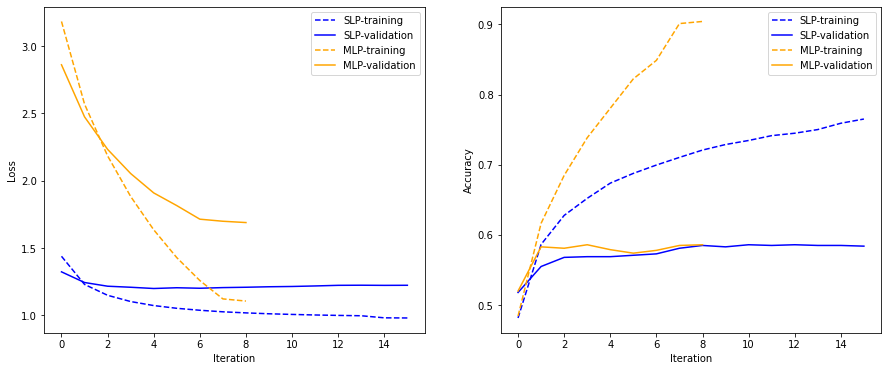

In [36]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(slp_history.history["loss"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_loss"], label="SLP-validation", color="blue")
plt.plot(mlp_history.history["loss"], label="MLP-training", color="orange", linestyle="dashed")
plt.plot(mlp_history.history["val_loss"], label="MLP-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(slp_history.history["accuracy"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_accuracy"], label="SLP-validation", color="blue")
plt.plot(mlp_history.history["accuracy"], label="MLP-training", color="orange", linestyle="dashed")
plt.plot(mlp_history.history["val_accuracy"], label="MLP-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Adding dropout to avoid overfitting

In [37]:
model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
drop_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=20, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 00008: early stopping
20/20 [==============================] - 0s 9ms/step - loss: 3.3731 - accuracy: 0.5985
training loss: 3.1950221061706543 training accuracy 0.7121999859809875
valid loss: 3.373110055923462 valid accuracy 0.5985000133514404


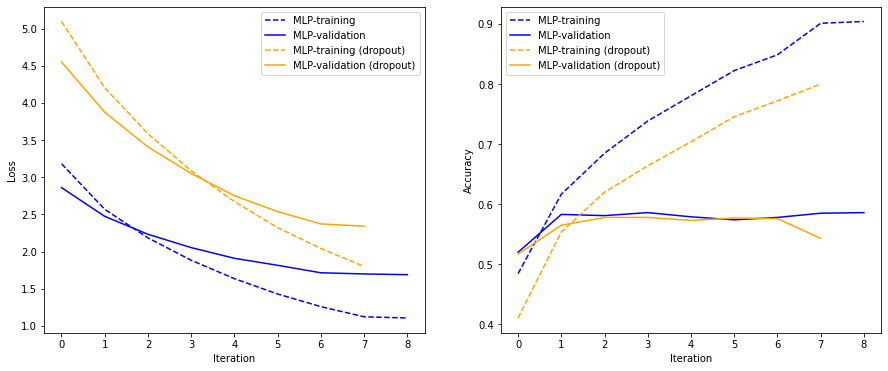

In [38]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(mlp_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(mlp_history.history["val_loss"], label="MLP-validation", color="blue")
plt.plot(drop_history.history["loss"], label="MLP-training (dropout)", color="orange", linestyle="dashed")
plt.plot(drop_history.history["val_loss"], label="MLP-validation (dropout)", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(mlp_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(mlp_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.plot(drop_history.history["accuracy"], label="MLP-training (dropout)", color="orange", linestyle="dashed")
plt.plot(drop_history.history["val_accuracy"], label="MLP-validation (dropout)", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Layer Normalisation vs Batch Normalisation

In [ ]:
histories = list()
for batch_norm in [False, True]:
    for layer_norm in [False, True]:
        model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                          num_layers=3, hidden_size=200, activation="relu",
                          batch_norm=batch_norm, layer_norm=layer_norm)
        checkpointer = keras.callbacks.ModelCheckpoint(
            filepath=os.path.join("models", "weights.hdf5"),
            monitor="val_accuracy",
            verbose=0,
            save_best_only=True)
        
        earlystopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            verbose=0)

        np.random.seed(0)
        tf.random.set_seed(0)
        history = model.fit(train_feats_matrix, train_label_matrix,
                            validation_split=0.1,
                            epochs=20, batch_size=100, verbose=0,
                            callbacks=[checkpointer, earlystopping])
        model = keras.models.load_model(os.path.join("models", "weights.hdf5"),
                                        custom_objects={"LayerNormalization": LayerNormalization})

        train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                     batch_size=100)
        valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
        
        histories.append((batch_norm, layer_norm, history))
        print("batch normalization:", batch_norm, "layer normalization:", layer_norm)        
        print("training loss:", train_score[0], "training accuracy", train_score[1])
        print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 3ms/step - loss: 0.9732 - accuracy: 0.5935
batch normalization: False layer normalization: False
training loss: 0.7867135405540466 training accuracy 0.6980999708175659
valid loss: 0.9732145071029663 valid accuracy 0.593500018119812
20/20 [==============================] - 0s 3ms/step - loss: 1.4560 - accuracy: 0.5535
batch normalization: False layer normalization: True
training loss: 0.16280031204223633 training accuracy 0.95660001039505
valid loss: 1.4560234546661377 valid accuracy 0.5534999966621399
20/20 [==============================] - 0s 3ms/step - loss: 1.6446 - accuracy: 0.5375
batch normalization: True layer normalization: False
training loss: 0.16054598987102509 training accuracy 0.9559999704360962
valid loss: 1.6445722579956055 valid accuracy 0.5375000238418579
20/20 [==============================] - 0s 3ms/step - loss: 1.4357 - accuracy: 0.5565
batch normalization: True layer normalization: True
training loss: 0.1545760631561279

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reus

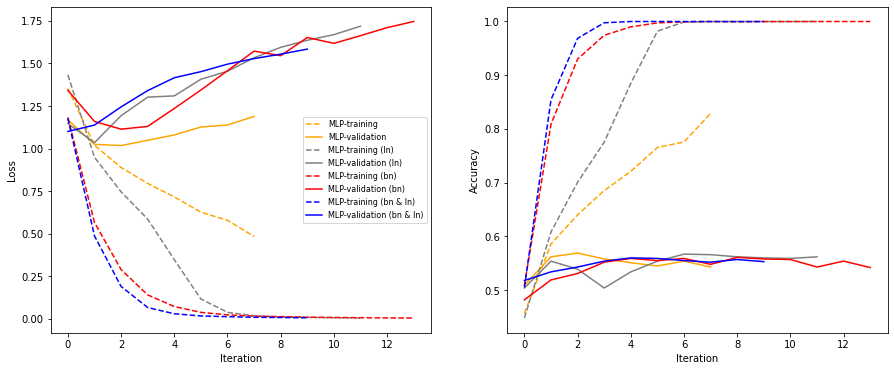

In [ ]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (batch_norm, layer_norm, history) in enumerate(histories):
    if batch_norm and layer_norm:
        name = " (bn & ln)"
    elif batch_norm and not layer_norm:
        name = " (bn)"
    elif not batch_norm and layer_norm:
        name = " (ln)"
    else:
        name = ""
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Residual Connection

In [ ]:
def build_Res_Net(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer network with residual connections,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_size,))
    
    if num_layers == 1:
        y = Dense(output_size,
                  activation="softmax",
                  input_dim=input_size,
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros",
                  kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    else:
        h = x
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                new_h = Dense(hidden_size,
                          input_dim=input_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            else:
                new_h = Dense(hidden_size,
                          input_dim=hidden_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            # add layer_norm
            if layer_norm:
                new_h = LayerNormalization()(new_h)
            # add batch_norm
            if batch_norm:
                new_h = BatchNormalization()(new_h)
            # residual connection
            if i == 0:
                h = new_h
            else:
                h = Add()([h, new_h])
            # add activation
            h = Activation(activation)(h)
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                h = Dropout(dropout_rate, seed=0)(h)
        # last layer: hidden -> class
        y = Dense(output_size,
                  activation="softmax",
                  input_dim=hidden_size,
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
model = build_Res_Net(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.1)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
# tf.random.set_seed(0)
res_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_split=0.1,
                        epochs=20, batch_size=100, verbose=0,
                        callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 3ms/step - loss: 3.8281 - accuracy: 0.5855
training loss: 3.707082509994507 training accuracy 0.6680999994277954
valid loss: 3.828061580657959 valid accuracy 0.5855000019073486


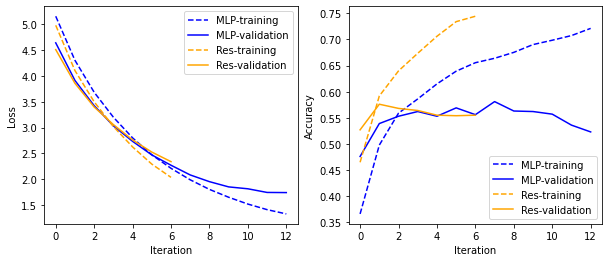

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(drop_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_loss"], label="MLP-validation", color="blue")
plt.plot(res_history.history["loss"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_loss"], label="Res-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(drop_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.plot(res_history.history["accuracy"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_accuracy"], label="Res-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Concatenation

In [ ]:
def build_Cat_Net(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer networks with concatenations,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_size,))
    
    if num_layers == 1:
        y = Dense(output_size,
                  activation="softmax",
                  input_dim=input_size,
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros",
                  kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    else:
        h = x
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                new_h = Dense(hidden_size,
                          input_dim=input_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            else:
                new_h = Dense(hidden_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            # add layer_norm
            if layer_norm:
                new_h = LayerNormalization()(new_h)
            # add batch_norm
            if batch_norm:
                new_h = BatchNormalization()(new_h)
            # residual connection
            if i == 0:
                h = new_h
            else:
                h = Concatenate()([h, new_h])
            # add activation
            h = Activation(activation)(h)
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                h = Dropout(dropout_rate, seed=0)(h)
        # last layer: hidden -> class
        y = Dense(output_size,
                  activation="softmax",
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
model = build_Cat_Net(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.0)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
# tf.random.set_seed(0)
cat_history = model.fit(train_feats_matrix, train_label_matrix,
                        validation_split=0.1,
                        epochs=20, batch_size=100, verbose=0,
                        callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

20/20 [==============================] - 0s 3ms/step - loss: 3.8455 - accuracy: 0.5815
training loss: 3.752880573272705 training accuracy 0.6389999985694885
valid loss: 3.8454501628875732 valid accuracy 0.5814999938011169


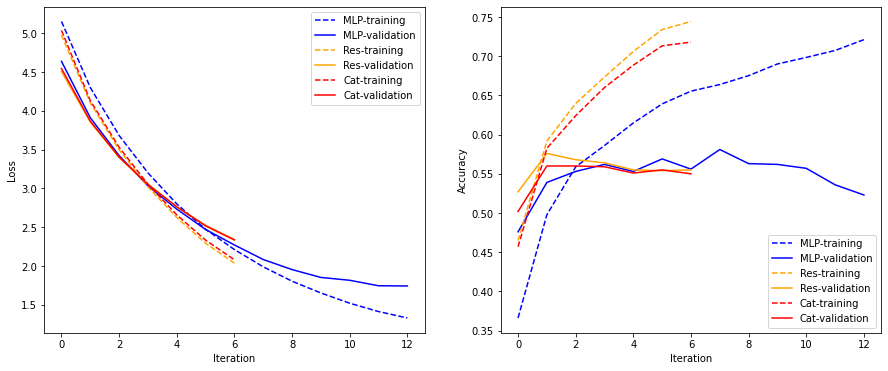

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(drop_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_loss"], label="MLP-validation", color="blue")
plt.plot(res_history.history["loss"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_loss"], label="Res-validation", color="orange")
plt.plot(cat_history.history["loss"], label="Cat-training", color="red", linestyle="dashed")
plt.plot(cat_history.history["val_loss"], label="Cat-validation", color="red")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(drop_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.plot(res_history.history["accuracy"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_accuracy"], label="Res-validation", color="orange")
plt.plot(cat_history.history["accuracy"], label="Cat-training", color="red", linestyle="dashed")
plt.plot(cat_history.history["val_accuracy"], label="Cat-validation", color="red")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Try to get the data from a data loader

Text Generator - To avoid shortage of RAM 

In [ ]:
BATCH_SIZE = 100
TARGET_SIZE = (128, 128, 3)
# AVERAGED_LATENT = sum_latent / total_images
class TextSequence(Sequence):
    def __init__(self, usage, x, y, shuf):
        self.usage = usage
        self.x = x
        self.y = y
        self.shuf = shuf

    def __len__(self):
        return len(self.x) // BATCH_SIZE

    def __getitem__(self, idx):
        index_sent = idx * BATCH_SIZE
        length = min(BATCH_SIZE, (len(self.x) - index_sent))
        batch_y = self.y[index_sent:index_sent+length]
        batch_x = self.x[index_sent:index_sent+length]

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuf == True:
            self.x, self.y = shuffle(self.x, self.y)

In [ ]:
# shuffle_x, shuffle_y = shuffle(train_feats_matrix, train_label_matrix)
train_sequence = TextSequence("Train", train_feats_matrix[:9000], train_label_matrix[:9000], True)
valid_sequence = TextSequence("Valid", train_feats_matrix[9000:], train_label_matrix[9000:], True)

In [ ]:
x, y = train_sequence.__getitem__(0)

In [ ]:
x.shape, y.shape

((100, 29979), (100, 5))

In [ ]:
os.makedirs("models", exist_ok=True)
# model = build_classifier(input_size=len(feats_dict), output_size=num_classes,
#                          l2_reg=0.005)

model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.6)

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_datagen.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=0)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

slp_history = model.fit_generator(generator=train_sequence,
                    epochs=20, steps_per_epoch=9000//100, callbacks=[checkpointer, earlystopping, reduce_lr], validation_data=valid_sequence, validation_steps=1000//100)

# slp_history = model.fit(train_feats_matrix, train_label_matrix,
#                     validation_split=0.1,
#                     epochs=100, batch_size=100, verbose=0,
#                     callbacks=[checkpointer, earlystopping, reduce_lr])
model = keras.models.load_model(os.path.join("models", "weights_datagen.hdf5"))

train_score = model.evaluate(train_feats_sparse, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_sparse, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
90/90 [==============================] - 1s 12ms/step - loss: 3.4075 - accuracy: 0.3767 - val_loss: 2.8724 - val_accuracy: 0.5370
Epoch 2/20
90/90 [==============================] - 1s 10ms/step - loss: 2.7318 - accuracy: 0.5759 - val_loss: 2.5028 - val_accuracy: 0.5780
Epoch 3/20
90/90 [==============================] - 1s 10ms/step - loss: 2.3534 - accuracy: 0.6277 - val_loss: 2.2479 - val_accuracy: 0.5900
Epoch 4/20
90/90 [==============================] - 1s 10ms/step - loss: 2.0389 - accuracy: 0.6803 - val_loss: 2.0631 - val_accuracy: 0.5760
Epoch 5/20
90/90 [==============================] - 1s 10ms/step - loss: 1.7883 - accuracy: 0.7253 - val_loss: 1.9250 - val_accuracy: 0.5680
Epoch 6/20
90/90 [==============================] - 1s 10ms/step - loss: 1.5912 - accuracy: 0.7553 - val_loss: 1.7917 - val_accuracy: 0.5850
Epoch 7/20
90/90 [==============================] - 1s 10ms/step - loss: 1.4306 - accuracy: 0.7951 - val_loss: 1.7772 - val_accuracy: 0.5770
Epoch 8/20
20